# Statistical inference of stock returns with linear regression

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [5]:
data = data[data.dollar_vol_rank<100]

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 106049 entries, ('000040', Timestamp('2014-05-08 00:00:00')) to ('900140', Timestamp('2015-04-29 00:00:00'))
Columns: 173 entries, volume to 회사_본부_및_경영_컨설팅_서비스업
dtypes: float64(39), uint8(134)
memory usage: 45.9+ MB


### Create Model Data

In [7]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
# X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume'], axis=1)

## Explore Data

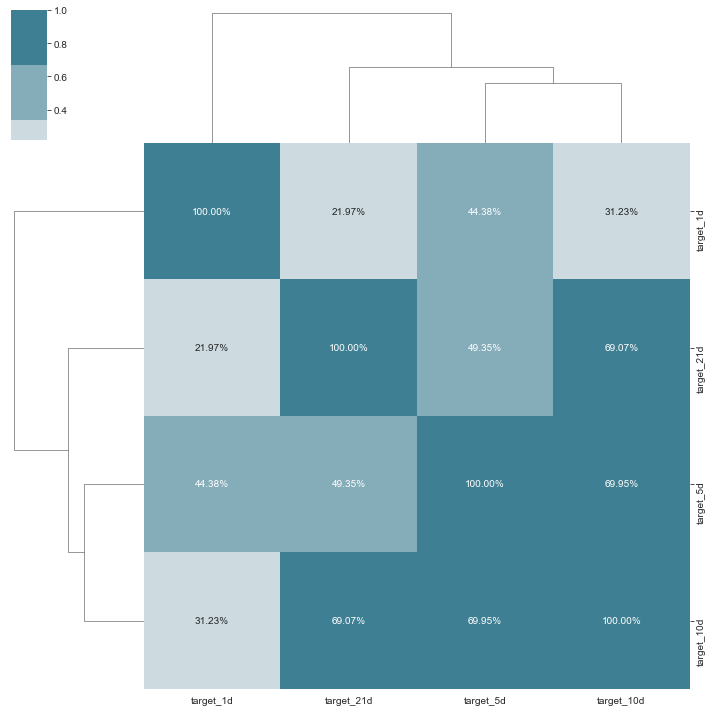

In [8]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

### 분모 분자 0인 값들 제거

In [9]:
use_col = X.columns[X.nunique() != 1]
X = X.reindex(columns=use_col)

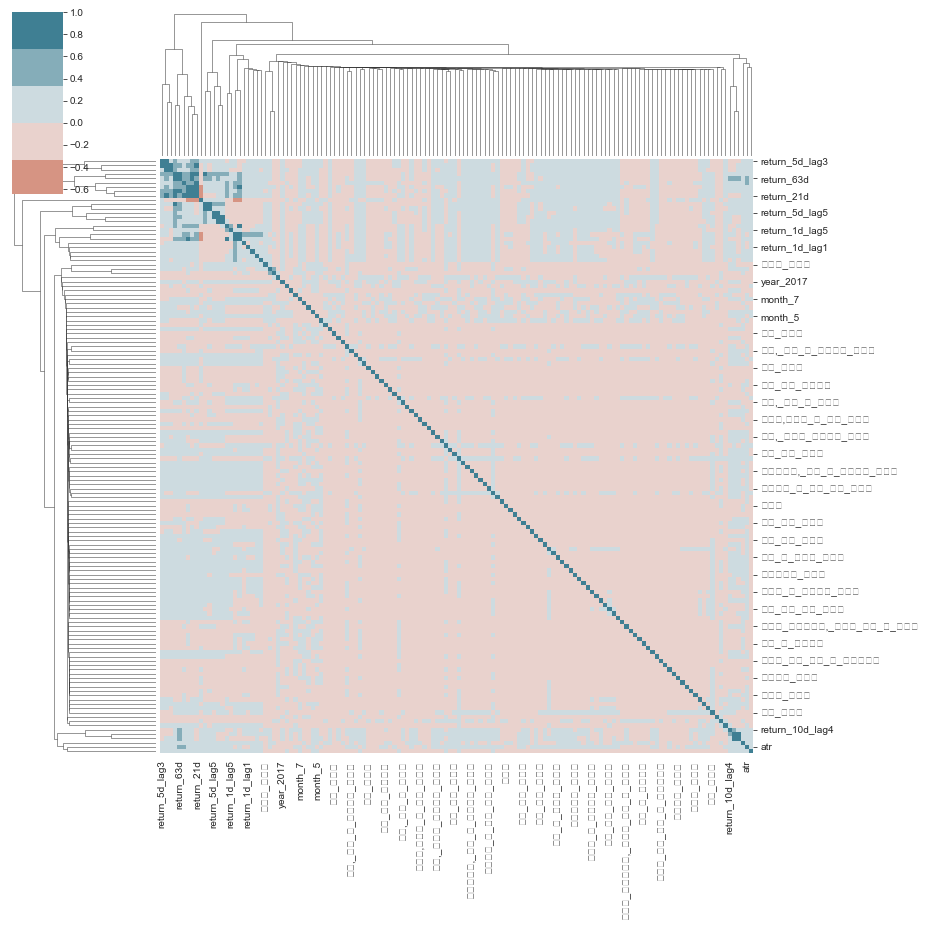

In [10]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [11]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [12]:
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
1391,return_42d,return_63d,0.839830
1528,return_63d,return_42d,0.839830
699,macd,return_21d,0.807730
1247,return_21d,macd,0.807730
700,macd,return_42d,0.771190
968,return_5d,bb_high,-0.598876
284,bb_high,return_10d,-0.637804
1106,return_10d,bb_high,-0.637804
277,bb_high,rsi,-0.641346
140,rsi,bb_high,-0.641346


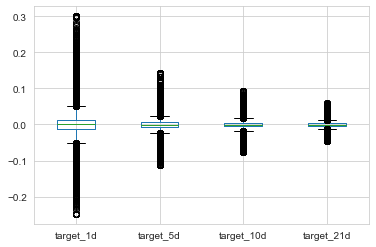

In [13]:
y.boxplot();

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [14]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

### 1-Day Returns

In [15]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     22.72
Date:                Fri, 25 Jun 2021   Prob (F-statistic):          8.18e-232
Time:                        16:14:30   Log-Likelihood:             2.2573e+05
No. Observations:              106049   AIC:                        -4.513e+05
Df Residuals:                  105991   BIC:                        -4.508e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### 5-Day Returns

In [16]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     67.74
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:14:31   Log-Likelihood:             3.1753e+05
No. Observations:              106049   AIC:                        -6.350e+05
Df Residuals:                  105991   BIC:                        -6.344e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### Obtain the residuals

In [17]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

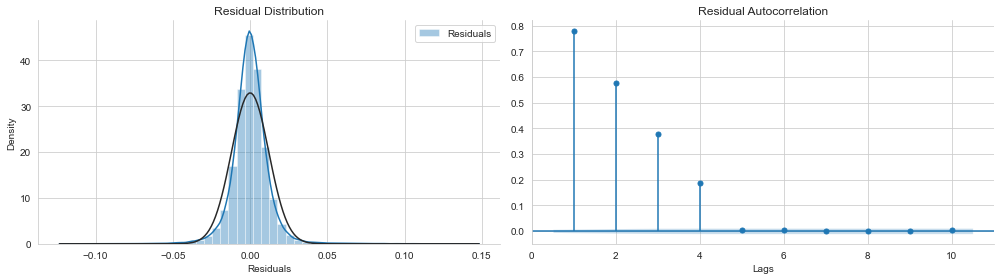

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

### 10-Day Returns

In [19]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     99.38
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:14:33   Log-Likelihood:             3.5830e+05
No. Observations:              106049   AIC:                        -7.165e+05
Df Residuals:                  105991   BIC:                        -7.159e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Monthly Returns

In [20]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     153.7
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:14:34   Log-Likelihood:             4.0089e+05
No. Observations:              106049   AIC:                        -8.017e+05
Df Residuals:                  105991   BIC:                        -8.011e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------